In [23]:
# import packages
import pandas as pd
import re
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
def get_vader_sentiment(s):
    return analyzer.polarity_scores(s)

def get_score_cats(compound_score):
    if compound_score >= 0.05:
        return "pos"
    if (-0.05 < compound_score < 0.05):
        return "neu"
    if compound_score <=-0.05:
        return "neg"
    else: return "N/A"


pd.set_option('max_colwidth', 100)
# read in df'

chatbot1 = pd.read_excel('./Chatbot_Activity_2022.xlsx')


In [24]:
import warnings
warnings.filterwarnings('ignore')

colsinterest_chatbot = ['ID', 'ACTIVITY_ID', 'USER_NAME', 'FROM_ID', 'FROM_NAME',
       'RECIPIENT_ID', 'RECIPIENT_NAME',  
       'LOCAL', 'TEXT', 'REPLY_TO_ID', 
       'TIME_STAMP', 'CONVERSATION_ID']

dfconvos = chatbot1[colsinterest_chatbot]

dfconvos["TIME_STAMP"] = pd.to_datetime(dfconvos["TIME_STAMP"])

100*dfconvos["LOCAL"].value_counts()/dfconvos.shape[0]
# ~3.5% of chatbot conversations


en-US    96.476678
es-ES     3.523322
Name: LOCAL, dtype: float64

In [25]:
chatbot1["RECIPIENT_ID"].nunique() # 34,719

34720

In [26]:
dfconvoshighlevel  =dfconvos.groupby(["CONVERSATION_ID"])["TIME_STAMP"].min().reset_index().rename(columns={"TIME_STAMP" : "TIME_STAMP_MIN"}).merge(
    dfconvos.groupby(["CONVERSATION_ID"])["TIME_STAMP"].max().reset_index().rename(columns={"TIME_STAMP" : "TIME_STAMP_MAX"})
, right_on='CONVERSATION_ID', left_on='CONVERSATION_ID')


dfconvoshighlevel["TIME_DIFF"] = (dfconvoshighlevel["TIME_STAMP_MAX"] - dfconvoshighlevel["TIME_STAMP_MIN"])
dfconvoshighlevel = dfconvoshighlevel.merge(
    dfconvos["CONVERSATION_ID"].value_counts().reset_index().rename(columns={"index": "CONVERSATION_ID", "CONVERSATION_ID":"NUMBER_MESSAGES"}),
    right_on='CONVERSATION_ID', left_on='CONVERSATION_ID'
)
dfconvoshighlevel.describe()

,TIME_DIFF,NUMBER_MESSAGES
count,41897,41897.000000
mean,0 days 00:03:13.845812349,16.720338
std,0 days 01:07:32.050050976,43.825092
min,0 days 00:00:00,1.000000
25%,0 days 00:00:17,6.000000
50%,0 days 00:00:42,9.000000
75%,0 days 00:01:33,15.000000
max,4 days 22:51:17,2159.000000


In [27]:
dfconvoshighlevel["TIME_DIFF"].mean() #average conversation is 3 minutes and 13 seconds

dfconvoshighlevel["TIME_DIFF"].std() #01:07:32.050050976 # 4 days 22:51:17 # 50th percentile 42seconds


# dfconvoshighlevel

Timedelta('0 days 01:07:32.050050976')

In [28]:
dfconvoshighlevel[["TIME_STAMP_MIN", "TIME_STAMP_MAX", "TIME_DIFF", "NUMBER_MESSAGES"]].sample(3)

,TIME_STAMP_MIN,TIME_STAMP_MAX,TIME_DIFF,NUMBER_MESSAGES
30080,2022-01-24 00:49:04,2022-01-24 00:49:19,0 days 00:00:15,5
728,2022-10-26 08:52:52,2022-10-26 08:53:00,0 days 00:00:08,4
40508,2022-08-25 17:09:45,2022-08-25 17:10:43,0 days 00:00:58,16


In [29]:

l = []
for k, val in chatbot1[colsinterest_chatbot].groupby(["CONVERSATION_ID"])["FROM_NAME"].value_counts().to_dict().items():

    l.append({"CONVERSATION_ID": k[0], "FROM_NAME": k[1],
              "NUMBER_MESSAGES_CAREERBOT": val})
dfmessagesusers = pd.DataFrame(l)

dfm1 = dfmessagesusers[dfmessagesusers["FROM_NAME"]=='CareerOneStop-CareerBot']
dfconvoshighlevel = dfconvoshighlevel.merge(dfm1.drop(columns=["FROM_NAME"]), right_on='CONVERSATION_ID', left_on='CONVERSATION_ID')

In [30]:
dfconvoshighlevel["NUMBER_MESSAGES_CUSTOMER"] = dfconvoshighlevel["NUMBER_MESSAGES"] - dfconvoshighlevel["NUMBER_MESSAGES_CAREERBOT"]



In [31]:
dfconvoshighlevel["MORE_CUSTOMER_CHATS"] = (dfconvoshighlevel["NUMBER_MESSAGES_CUSTOMER"]>dfconvoshighlevel["NUMBER_MESSAGES_CAREERBOT"])



# In 77 instances the 
lcustomerchatsmore = dfconvoshighlevel[dfconvoshighlevel["MORE_CUSTOMER_CHATS"]==True]["CONVERSATION_ID"].tolist()

In [32]:
pd.set_option("max_colwidth",200)
dfconvos["MSG_ORDER"] =  dfconvos.groupby(["CONVERSATION_ID"]).cumcount()+1


In [33]:
#dfconvoshighlevel.merge(chatbot2, on='CONVERSATION_ID')
#chatbot2[chatbot2["CONVERSATION_ID"
#chatbot1[colsinterest_chatbot].merge(chatbot[["CONVERSATION_ID", "TIME_STAMP"]
dfconvos["sentiment"] = dfconvos["TEXT"].map(lambda x: get_vader_sentiment(str(x)))
dfconvos["sentiment_score"] = dfconvos["sentiment"].map(lambda x: x.get("compound"))
dfconvos["sentiment_category"] = dfconvos["sentiment"].map(lambda x: get_score_cats(x.get("compound")))

In [37]:
dfconvos[dfconvos["FROM_NAME"]=='You']["TEXT"].value_counts().to_frame().head(10)

,TEXT
hi,13562
Hi,11023
Search jobs now,6766
Job search,5162
no,4771
Explore careers,4434
g,3573
menu,3567
Education and training,3513
Search job postings,3183


In [38]:
dfconvosusermessages = dfconvos[dfconvos["RECIPIENT_NAME"]=="CareerOneStop-CareerBot"].sort_values("TIME_STAMP")
dfconvosusermessages["MSG_USER_ORDER"] =  dfconvosusermessages.groupby(["CONVERSATION_ID"]).cumcount()+1


In [39]:
dfconvos["FROM_NAME"] = dfconvos["FROM_NAME"].map(lambda x: {"You": "Customer"}.get(x, x))


```python
if you want to display
for c in cl:
    display.display(
        dfconvos[dfconvos["CONVERSATION_ID"]==c][["CONVERSATION_ID", "TIME_STAMP", "FROM_NAME","MSG_ORDER", "TEXT", "sentiment_score"]].set_index(["MSG_ORDER","FROM_NAME"])
    )
```


In [40]:
dfconvoshighlevel[(dfconvoshighlevel["NUMBER_MESSAGES_CUSTOMER"]<40) & (dfconvoshighlevel["NUMBER_MESSAGES_CUSTOMER"]>10)]

cl = dfconvos[dfconvos["sentiment_category"]=="neg"]["CONVERSATION_ID"].unique()

In [45]:
import numpy
import matplotlib.pyplot as plt
import seaborn as sns

#### One of the things we would like to understand is if there might be common patterns in a user's sentiment throughout their conversation with the chatbot. This may provide insight into categorizing a user's experience and satisfaction. To do this we'd like to explore clustering the conversations to see if there are any groupings that show common trends throughout the engagement.

Since we are particularly interested in the user's sentiment (and how that might reflect their experience throughout the conversation), we will only look at the user's messages.
We will also limit the data to conversations that were longer, but still within a reasonable range (here we consider converations with between 10 and 20 user messages

In [51]:
# add a column that meaures the number of user messages there are within the conversation
dfconvosusermessages = dfconvosusermessages.merge(
    dfconvosusermessages.groupby('CONVERSATION_ID')['ID'].count().rename('CONVERSATION_USER_LENGTH').reset_index(), 
    on='CONVERSATION_ID'
)

<Axes: >

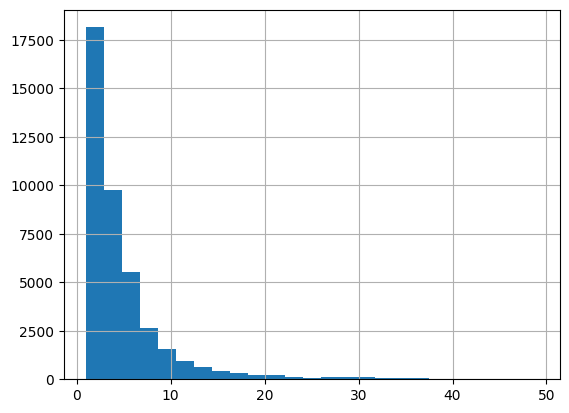

In [52]:
# here we can see that the majority of conversations contain 10 or fewer user messages,
# however to improve our ability to identify lusters we would like to look at conversations with a longer number of user messages
# in this case there is still a reasonable number of conversations with a user message count between 10 and 20.
dfconvosusermessages[dfconvosusermessages.CONVERSATION_USER_LENGTH<50].drop_duplicates('CONVERSATION_ID').CONVERSATION_USER_LENGTH.hist(bins=25)

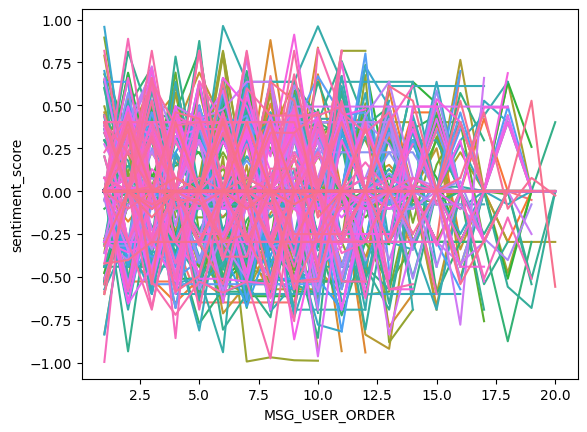

In [53]:
# Let's plot some convos just to see how noisy they are
# we'll pick a sample of 1000 convos where the number of user messages is between 10-20

sample_convo_ids = dfconvosusermessages[(dfconvosusermessages['CONVERSATION_USER_LENGTH']>=10)&(dfconvosusermessages['CONVERSATION_USER_LENGTH']<=20)].CONVERSATION_ID.drop_duplicates().sample(1000)
sample_convos = dfconvosusermessages[dfconvosusermessages['CONVERSATION_ID'].isin(sample_convo_ids)]

sns.lineplot(data=sample_convos,
             x="MSG_USER_ORDER", y="sentiment_score", hue='CONVERSATION_ID', legend=False)
plt.show()

#### As we can see above, the sentiment plots of the user messages seem to be quite noisy. This isn't a good sign for being able to cluster them effectively, but we will go ahead and try

#### For clustering, we are using Dynamic Time Warping (DTW), which is a method that tries to cluster sequences by "stretching" or "squishing" them in nonlinear ways but that preserve the sequence's shape, thus hopefully allowing us to determine if there are "common patterns" or trends in sentiment over a user's conversation with the chatbot. 

Also DTW is beneficial since it can handle variable-length sequences, and in this case the length of the user dialogue (e.g. how many messages there are from the user in a given conversation) varies from one chat to the other

Note that we are only including the sentiment scores of the user messages.

In [54]:


from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

In [55]:
# We will limit the data to just those that have a reasonable number of user messages, 10-20
user_msg_count_min = 10
user_msg_count_max = 20
dtw_data = (
    dfconvosusermessages
    [(dfconvosusermessages['CONVERSATION_USER_LENGTH']>user_msg_count_min)&(dfconvosusermessages['CONVERSATION_USER_LENGTH']<user_msg_count_max)]
    .groupby('CONVERSATION_ID')
    ['sentiment_score']
    .agg(list)
)
# convert it into a viariable length time series array
sentiment_array = to_time_series_dataset(dtw_data.to_list())

In [56]:
# now we apply the k means clustering using DTW
# We will keep our assumptions simple and try 3 clusters. If we dont see some separation between the clusters then there might not be much reason to try higher numbers
# tho for a more rigorous approach in the future we can use the silhoette method to determine the optimal number of clusters.

n_clusters = 3
km_bis = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", random_state=0)
labels = km_bis.fit_predict(sentiment_array)

In [57]:
# let's add the cluster labels back to the data
# we'll create a new dataframe mapping the convo id to the label, then merge this onto the main dataframes
df_cluster_labels = pd.DataFrame({'CONVERSATION_ID': dtw_data.index, 'USER_MSG_CLUSTER_ID': labels})

dfconvosusermessages = dfconvosusermessages.merge(df_cluster_labels, on='CONVERSATION_ID', how='left')

#let's also add it to the datafram that has the entire convo including the chatbot messages
dfconvos = dfconvos.merge(df_cluster_labels, on='CONVERSATION_ID', how='left')

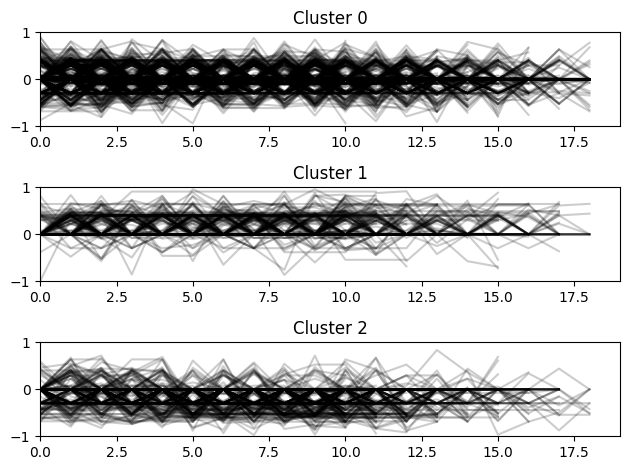

In [58]:
# Now that we have grouped the convos into clusters, let's plot the cluster groups to see if we can see anything visually distinctive between them
plt.figure()
for yi in range(n_clusters):
    plt.subplot(n_clusters, 1, 1 + yi)
    for xx in sentiment_array[labels == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, user_msg_count_max-1)
    plt.ylim(-1, 1)
    plt.title("Cluster %d" % (yi))

plt.tight_layout()
plt.show()

#### As can see above, there does not appear to be distinctive differences between the clusters. In this case we cannot definitively say there are 'common patterns' of user sentiment in the data that might help with segmenting user experience. That being said, we do see that in cluster 0 the user responses seem to end with a more negative sentiment compared to the other clusters

Further exploration can be done to see if we can improve the signal within the sentiment sequences. There does appear to be a fair amount of noise, where sentiment jumps from strong positive to strong negative, and vice versa -- It would be interesting to understand the driver for this, for example single word responses to questions by the chatbot like: 'Yes', 'No', etc. or by common navigational prompts like 'job search' or 'find specialist'

In [59]:
## let's take a look at cluster 1, where there may be some trend indicating these tend to shorter conversations and the sentiment tends more negative towards the end

# we will just look at the last message submitted by the human user, and sort by the sentiment, to see if there does seem to be more negative responses
df_last_user_msg = dfconvos[(dfconvos.FROM_NAME=='Customer')].sort_values('MSG_ORDER').groupby('CONVERSATION_ID').last()


df_last_user_msg[(df_last_user_msg.USER_MSG_CLUSTER_ID==1)].sort_values('sentiment_score')

,ID,ACTIVITY_ID,USER_NAME,FROM_ID,FROM_NAME,RECIPIENT_ID,RECIPIENT_NAME,LOCAL,TEXT,REPLY_TO_ID,TIME_STAMP,MSG_ORDER,sentiment,sentiment_score,sentiment_category,USER_MSG_CLUSTER_ID
CONVERSATION_ID,,,,,,,,,,,,,,,,
6noEPNzOuoVBcD5uCC8k2q-us,6476808,6noEPNzOuoVBcD5uCC8k2q-us|0000057,da50b1b6-71d6-48da-9557-695ea0653f1f,420b058c-6393-4d4f-b95b-ea08e7b19a3b,Customer,CareerOneStop-CareerBot@bsFShu3uYPA,CareerOneStop-CareerBot,en-US,"fortnite battle pass, i shoved a marker up my ass",None,2022-03-31 13:56:20,43,"{'neg': 0.433, 'neu': 0.567, 'pos': 0.0, 'compound': -0.7269}",-0.7269,neg,1.0
6O7gyMoOwC0FeiVmvRqNfe-us,6602707,6O7gyMoOwC0FeiVmvRqNfe-us|0000057,cfb60475-a7c3-4b46-ad19-76815aa0552e,dc7754b3-ca6f-4cce-a125-ea1cb0a26d58,Customer,CareerOneStop-CareerBot@bsFShu3uYPA,CareerOneStop-CareerBot,en-US,How to kill myself,None,2022-05-13 12:30:15,45,"{'neg': 0.61, 'neu': 0.39, 'pos': 0.0, 'compound': -0.6908}",-0.6908,neg,1.0
BcQJQFvSGog5njjr5LbcyL-us,6400235,BcQJQFvSGog5njjr5LbcyL-us|0000047,d7b21032-f7a0-4a91-8515-73e9a26d6c9a,d76b187d-a3a7-4e83-b67b-88b2dab39698,Customer,CareerOneStop-CareerBot@bsFShu3uYPA,CareerOneStop-CareerBot,en-US,fuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck youfuck...,None,2022-03-03 11:11:54,36,"{'neg': 0.123, 'neu': 0.877, 'pos': 0.0, 'compound': -0.5423}",-0.5423,neg,1.0
HJpE1NEHkl7CIWISbrcES2-us,6541356,HJpE1NEHkl7CIWISbrcES2-us|0000056,023518d4-c0c3-4565-bb41-5e375f456964,0795b615-9fd0-4dd3-875c-b9e41c3c860a,Customer,CareerOneStop-CareerBot@bsFShu3uYPA,CareerOneStop-CareerBot,en-US,fuck you,None,2022-04-27 15:09:01,40,"{'neg': 0.778, 'neu': 0.222, 'pos': 0.0, 'compound': -0.5423}",-0.5423,neg,1.0
AvJlIUW63NY4k0adNLd4Va-us,6507729,AvJlIUW63NY4k0adNLd4Va-us|0000048,6050f480-57be-45ac-a6cd-0dc0cd82defa,8d350f12-b958-4a2b-aa11-5e0b888305cb,Customer,CareerOneStop-CareerBot@bsFShu3uYPA,CareerOneStop-CareerBot,en-US,Ssi emergency,None,2022-04-13 08:57:34,30,"{'neg': 0.722, 'neu': 0.278, 'pos': 0.0, 'compound': -0.3818}",-0.3818,neg,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4PbJN6NAg1M6k56tBeixZg-us,6298022,4PbJN6NAg1M6k56tBeixZg-us|0000051,bdb097cb-9b2a-4fe0-84ca-689a334505fd,e69c98b7-b890-4fdb-b13a-6cb5df921483,Customer,CareerOneStop-CareerBot@bsFShu3uYPA,CareerOneStop-CareerBot,en-US,dear Highbury Rahab Rahab Rahab Rahab Rahab the mural put the real quick earlier for # ha ha,None,2022-01-25 09:11:35,39,"{'neg': 0.0, 'neu': 0.67, 'pos': 0.33, 'compound': 0.7506}",0.7506,pos,1.0
KzOuUEclkia4YtoaHsLsgk-us,6399811,KzOuUEclkia4YtoaHsLsgk-us|0000032,f773c096-2631-4f90-91f8-cfb10af56e7a,35a457b2-1fa5-4d67-9b79-298626663f29,Customer,CareerOneStop-CareerBot@bsFShu3uYPA,CareerOneStop-CareerBot,en-US,"Hi, welcome to CareerBot. I’m not a real person but I can help you find what you need on the CareerOneStop website. Please say Hi to get started. bru You can type a word or question below—or yo...",None,2022-03-03 09:54:10,28,"{'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'compound': 0.8176}",0.8176,pos,1.0
GEQZu7ke3geEkjsr8sCaoC-us,6921453,GEQZu7ke3geEkjsr8sCaoC-us|0000027,fb105e92-a38e-4b5b-8596-08089df74c94,ee1ceacb-b9b5-491c-9831-a8d2122af466,Customer,CareerOneStop-CareerBot@bsFShu3uYPA,CareerOneStop-CareerBot,en-US,"Hi, welcome to CareerBot. I’m not a real person, but I can help you find what you need on the CareerOneStop website. Please say Hi to get started. HI You can type a word or question below—or yo...",None,2022-11-30 16:59:21,26,"{'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'compound': 0.8176}",0.8176,pos,1.0


/Users/isabelmetzger/miniconda3/envs/cxenv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


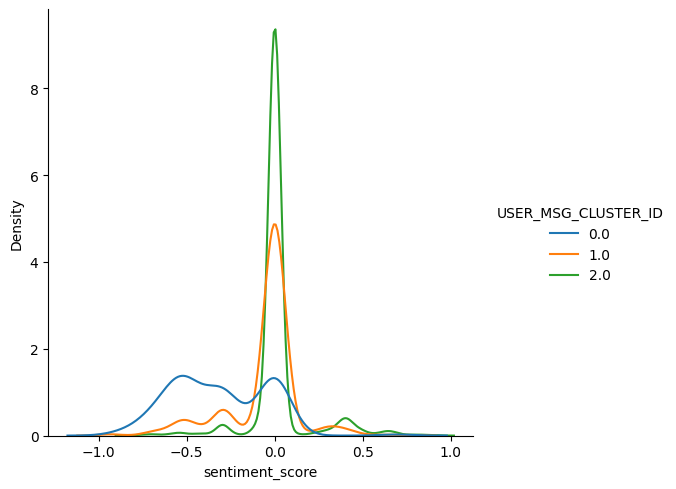

In [474]:
# To verify our hunch that the last user messages in cluster 1 seem more negative overall and compared to the other clusters,
# Let's actually look at the sentiment distribution across clusters

sns.displot(data=df_last_user_msg, x="sentiment_score", hue='USER_MSG_CLUSTER_ID', kind="kde", palette='tab10', common_norm=False)

#### When we look at the last user message for the conversations in cluster 0, and we compare the distribution to the other clusters, it does seem to match what appears in the cluster line plot above, which is that there cluster 0 tends to end with more negative user sentiment.

When we visually inspect cluster 0 we also seem to notice it contains a larger number of conversations that end with argumentative and or profane user messages, and we suspect this is due to a combination of spam and users that are engaging with the chatbot not for its intended purpose.

This leads us to believe that we can further improve our analysis and the signal in our dataset by identifying and removing as many of these conversations. Further exploration can be done to try to efficiently and effectively identify and remove these conversations

In [60]:

df_last_user_msg["TEXT_LEN"] = df_last_user_msg["TEXT"].map(len)

# How can I get in touch with someone who can help me with the unemployment benefits	# I have been applying for unemployment on a website benefits guide
# df_last_user_msg[(df_last_user_msg.USER_MSG_CLUSTER_ID==1)].sort_values('TEXT_LEN', ascending=False).head(20)

In [61]:
# i hate you you are the worst app ever you dmb stupid robot	
df_last_user_msg = df_last_user_msg.reset_index()

In [62]:
# df_last_user_msg[df_last_user_msg["CONVERSATION_ID"].isin(
#     df_last_user_msg[(df_last_user_msg.USER_MSG_CLUSTER_ID==2)]["CONVERSATION_ID"].dropna().unique()
# )]

#df_last_user_msg[(df_last_user_msg["TEXT"].map(lambda x: True if 'unemployment' in str(x).lower() else False))].sort_values("USER_MSG_CLUSTER_ID").head()

In [63]:
# 886
print(100*886/41883) # %2 of last messages
print(df_last_user_msg.shape[0])

2.1154167562018005
41883


In [43]:
chatbot1["FROM_NAME"].value_counts() # 259790 -- 25,9803 #with the plus 13

CareerOneStop-CareerBot    440728
You                        259790
User                           13
Name: FROM_NAME, dtype: int64